<p style="font-size:36px;text-align:center"> <b>Prediction of stock prices for the next day</b> </p>

## Real world/Buisness objectives and contraints

* No low-latency requirement
* Interpretaibility is important
* Errors can be very costly


## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

C:\Users\Rajat\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Displaying and Understanding all the datsets

In [2]:
prices=pd.read_csv("C:\\Users\\Rajat\\Downloads\\prices.csv")
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
prices.shape

(851264, 7)

In [4]:
prices['symbol'].value_counts()

GLW     1762
EMR     1762
NOC     1762
WBA     1762
DVN     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

In [5]:
prices_split=pd.read_csv("C:\\Users\\Rajat\\Downloads\\prices-split-adjusted.csv")
prices_split.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
prices_split.shape

(851264, 7)

In [7]:
security=pd.read_csv("C:\\Users\\Rajat\\Downloads\\securities.csv")
security.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [8]:
security.shape

(505, 8)

In [9]:
security['GICS Sector'].value_counts()

Consumer Discretionary         85
Industrials                    69
Information Technology         68
Financials                     64
Health Care                    59
Consumer Staples               37
Energy                         36
Real Estate                    29
Utilities                      28
Materials                      25
Telecommunications Services     5
Name: GICS Sector, dtype: int64

In [10]:
fundamentals=pd.read_csv("C:\\Users\\Rajat\\Downloads\\fundamentals.csv")
fundamentals.head()

,Z,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,31-12-2012,3.068000e+09,-222000000,-1961000000,23,-1888000000,4.695000e+09,53.0,...,7.072000e+09,9011000000,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,31-12-2013,4.975000e+09,-93000000,-2723000000,67,-3114000000,1.059200e+10,75.0,...,1.432300e+10,13806000000,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,31-12-2014,4.668000e+09,-160000000,-150000000,143,-5311000000,1.513500e+10,60.0,...,1.175000e+10,13404000000,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,31-12-2015,5.102000e+09,352000000,-708000000,135,-6151000000,1.159100e+10,51.0,...,9.985000e+09,13605000000,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,29-12-2012,2.409453e+09,-89482000,600000,32,-271182000,5.202150e+08,23.0,...,3.184200e+09,2559638000,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [11]:
fundamentals.shape

(1781, 79)

# Selecting some point from full dataset for better visualization

In [12]:
prices1=prices[0:250]
prices2=prices_split[0:250]

In [13]:
prices1['date'] = pd.to_datetime(prices1.date,format='%Y-%m-%d')
prices1.index = prices1['date']

# Plotting Time-Series Graph for features of the dataset

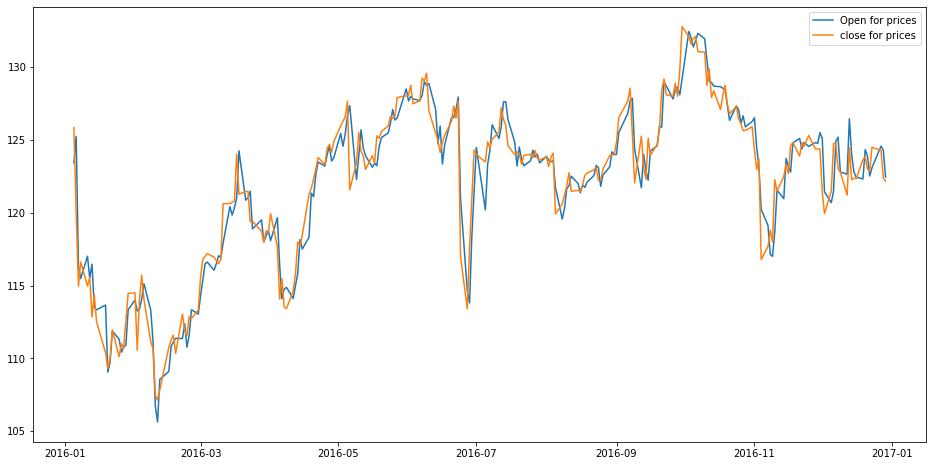

In [14]:
#plot
plt.figure(figsize=(16,8))
plt.plot(prices1['open'], label='Open for prices')
plt.legend()
plt.plot(prices1['close'], label='close for prices')
plt.legend()

#  Analysing the Relation among features from the datset

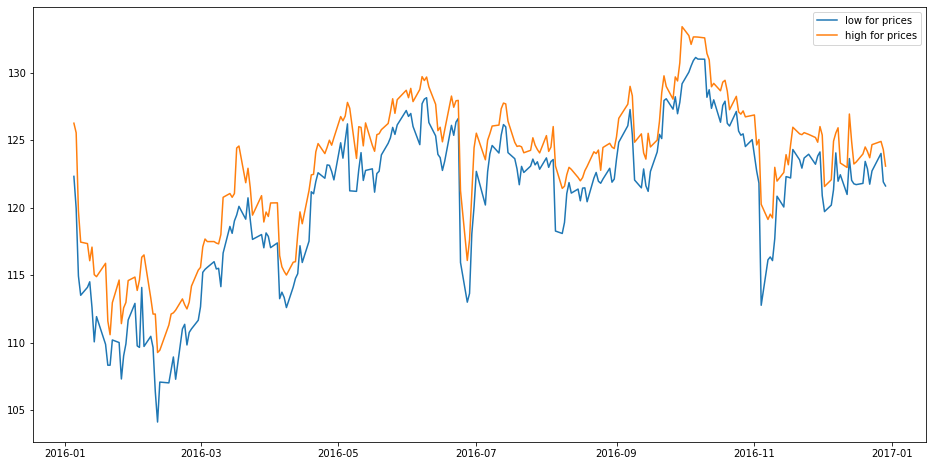

In [15]:
prices1['date'] = pd.to_datetime(prices1.date,format='%Y-%m-%d')
prices1.index = prices1['date']


#plot
plt.figure(figsize=(16,8))
plt.plot(prices1['low'], label='low for prices')
plt.legend()
plt.plot(prices1['high'], label='high for prices')
plt.legend()

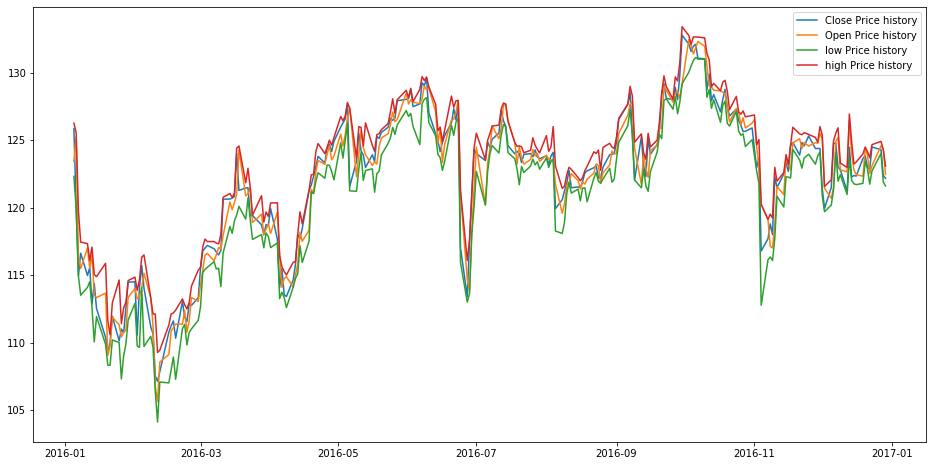

In [16]:
#setting index as date
prices2['date'] = pd.to_datetime(prices2.date,format='%Y-%m-%d')
prices2.index = prices2['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(prices2['close'], label='Close Price history')
plt.legend()
plt.plot(prices2['open'], label='Open Price history')
plt.legend()
plt.plot(prices2['low'], label='low Price history')
plt.legend()
plt.plot(prices2['high'], label='high Price history')
plt.legend()


# Doing Standardisation

In [17]:
scalar=StandardScaler()
stan_data_prices=scalar.fit_transform(prices[['open','close','low','high']])

In [18]:
scalar=StandardScaler()
stan_data_prices_split=scalar.fit_transform(prices_split[['open','close','low','high']])

In [19]:
stan_data_prices

array([[ 0.62838275,  0.65698561,  0.62974564,  0.64767927],
       [ 0.65000865,  0.58696508,  0.60114918,  0.63927348],
       [ 0.54414912,  0.52686198,  0.5406983 ,  0.57060632],
       ...,
       [-0.20547007, -0.20704009, -0.20329361, -0.21077817],
       [-0.31192697, -0.30358726, -0.3101987 , -0.30726735],
       [-0.19877915, -0.20584518, -0.20184569, -0.20201722]])

In [20]:
stan_data_prices_split

array([[ 0.77703978,  0.80887148,  0.77859074,  0.79848234],
       [ 0.80110767,  0.73094726,  0.7467614 ,  0.78912878],
       [ 0.68329454,  0.66405992,  0.67947645,  0.71271927],
       ...,
       [-0.15097125, -0.15268264, -0.14862502, -0.15676781],
       [-0.26944921, -0.26012775, -0.26761592, -0.26413633],
       [-0.14352479, -0.15135285, -0.14701342, -0.14701904]])

In [21]:
f2=fundamentals.drop(['Ticker Symbol','Period Ending'], axis = 1) 

In [22]:
stan_fund=scalar.fit_transform(f2)

In [23]:
stan_fund

array([[-1.73107856e+00, -1.14220394e-01, -2.09591399e-01, ...,
        -6.54410604e-02, -1.90731974e+00, -2.34127082e-01],
       [-1.72913353e+00,  2.14695782e-02, -3.89716182e-02, ...,
        -1.53080327e-02, -3.11088345e+00, -3.84691728e-01],
       [-1.72718850e+00, -3.74586228e-04, -1.27588093e-01, ...,
         3.48249950e-02,  1.41933864e-01,  1.00235655e-01],
       ...,
       [ 1.72718850e+00, -2.56314194e-01,  1.75295083e-01, ...,
         3.48249950e-02, -4.67303695e-01, -8.74072077e-02],
       [ 1.72913353e+00, -2.39095015e-01,  7.32057027e-03, ...,
         8.49580227e-02, -5.69553355e-01, -9.09588870e-02],
       [ 1.73107856e+00, -2.55958425e-01,  1.03872849e-01, ...,
                    nan,             nan,             nan]])

In [24]:
x1=prices.drop(['date','symbol'], axis = 1) 

In [25]:
X=x1.iloc[1:,:-1].values
y=prices.iloc[:,-1].values

In [26]:
#ct=ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])],remainder='passthrough')

# LINEAR REGRESSION ON PRICES (.CSV) DATASET

In [27]:
X=stan_data_prices

In [28]:
print(X)

[[ 0.62838275  0.65698561  0.62974564  0.64767927]
 [ 0.65000865  0.58696508  0.60114918  0.63927348]
 [ 0.54414912  0.52686198  0.5406983   0.57060632]
 ...
 [-0.20547007 -0.20704009 -0.20329361 -0.21077817]
 [-0.31192697 -0.30358726 -0.3101987  -0.30726735]
 [-0.19877915 -0.20584518 -0.20184569 -0.20201722]]


# Splitting dataset into Training and Testing data.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Importing Model from Sk-learn

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
y_pred = model.predict(X_test)
np.set_printoptions(precision=2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
print(y_pred.shape)
X_test.shape

(170253,)


(170253, 4)

# Graph Plotting

<function matplotlib.pyplot.show(*args, **kw)>

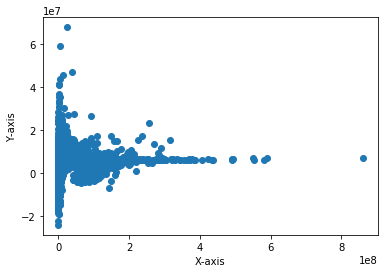

In [32]:
plt.scatter(y_test,y_pred)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show

In [33]:
y_pred

array([5305437.28, 5357598.25, 4097191.83, ..., 5124618.43, 4850507.23,
       5195567.18])




</br></br><p style="font-size:36px"> <b> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ThankYou</b> </p>


